In [32]:
# Importando pacotes necessários
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from scipy.stats import spearmanr

from collections import Counter





In [154]:
## Utilizar esse caso esteja usando o Google Colab

#from google.colab import drive
#drive.mount('/content/drive')

#Carregar arquivo do drive
#df = pd.read_csv('/content/drive/MyDrive/Períodos/2024-2/Aprendizado de Máquina/Projeto/dados.csv')

In [33]:
# Carregar o arquivo 'dados.csv' no dataframe
df = pd.read_csv('dados.csv')

# Exibir as primeiras linhas do dataframe para verificar se foi carregado corretamente
print(df.head())

   Qtd_Moradores  Maquina_de_Lavar_1  Geladeiras_1  Freezer_1  \
0            3.0                 0.0           1.0        0.0   
1            2.0                 0.0           1.0        1.0   
2            2.0                 0.0           1.0        0.0   
3            2.0                 1.0           1.0        1.0   
4            2.0                 1.0           1.0        1.0   

   Microcomputador  Lava_Loucas_1  Microondas_1  Ar_Condicionado  Televisao  \
0              0.0            0.0           0.0              0.0        1.0   
1              1.0            0.0           0.0              0.0        2.0   
2              0.0            0.0           0.0              0.0        1.0   
3              1.0            0.0           1.0              1.0        2.0   
4              1.0            0.0           1.0              0.0        2.0   

   Batedeira  ...  Secadora_Centrifuga  Aquecedor_de_Ambiente  \
0        1.0  ...                  0.0                    0.0   
1   

In [34]:
# Criar um dicionário de mapeamento
classe_map = {1: 'A', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2', 6: 'DE'}

# Substituir os valores da coluna 'CLASSE'
df['CLASSE'] = df['CLASSE'].map(classe_map)

# Verificar a alteração
print(df['CLASSE'].unique())

['C1' 'C2' 'DE' 'B2' 'B1' 'A']


In [35]:
contagem = df['CLASSE'].value_counts()
print(contagem)


CLASSE
C1    293
C2    262
B2    250
DE    176
B1     75
A      40
Name: count, dtype: int64


Aplicando o PCA

In [36]:
# Separar as variáveis independentes (X) e a variável dependente (y)
dados_sem_classe = df.drop('CLASSE', axis=1)
classe_1 = df['CLASSE']

In [37]:
# Padronizar os dados antes de aplicar o PCA
scaler = StandardScaler()
dadosPCA_scaled = scaler.fit_transform(dados_sem_classe)

In [38]:
# Aplicar PCA
pca = PCA()
dadosPCA_reduced = pca.fit_transform(dadosPCA_scaled)

In [39]:
# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

In [40]:
# Variância acumulada
cumulative_variance = np.cumsum(explained_variance)

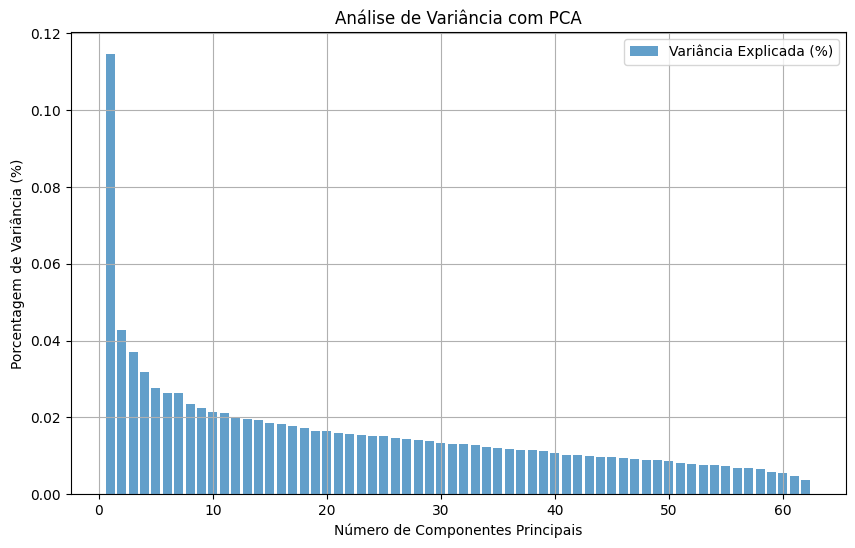

In [41]:
# Plotar a variância explicada e a acumulada em gráficos de barras
plt.figure(figsize=(10, 6))

# Gráfico de barras para a variância explicada
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Variância Explicada (%)')
plt.title('Análise de Variância com PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem de Variância (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [42]:
# Encontrar o número de componentes que explicam
n_components = np.argmax(cumulative_variance >= 0.8) + 1

print(f"Número de componentes principais: {n_components}")

Número de componentes principais: 38


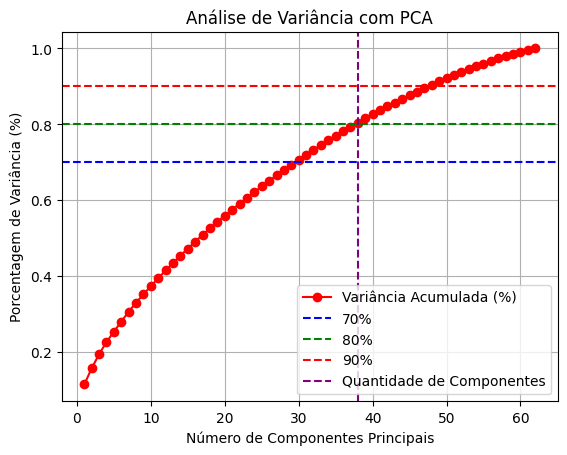

In [43]:
# Gráfico de linha para a variância acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Variância Acumulada (%)')
plt.title('Análise de Variância com PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem de Variância (%)')

plt.axhline(y=0.70, color='blue', linestyle='--', linewidth=1.5, label='70%')
plt.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, label='80%')
plt.axhline(y=0.90, color='red', linestyle='--', linewidth=1.5, label='90%')


plt.axvline(x=n_components, color='purple', linestyle='--', linewidth=1.5, label='Quantidade de Componentes')


plt.legend(loc='best')
plt.grid(True)
plt.show()

In [44]:
# Aplicar PCA com o número de componentes selecionados
pca = PCA(n_components=n_components)
dadosPCA_reduced = pca.fit_transform(dadosPCA_scaled)

In [45]:
# Criar um DataFrame com as componentes principais
df_pca = pd.DataFrame(dadosPCA_reduced, columns=[f'PC{i+1}' for i in range(n_components)])


In [46]:
# Adicionar a coluna da variável alvo
df_pca['CLASSE'] = classe_1.reset_index(drop=True)


In [47]:
#Dataframe criado com as componentes principais

df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,CLASSE
0,-2.204496,-1.006844,0.292810,2.228440,1.691404,0.738880,0.096084,0.678316,-0.263904,0.549220,...,1.149779,-0.526078,-0.671314,-0.850601,0.287521,-0.236243,-0.104761,1.127899,-0.391934,C1
1,-2.261331,-1.212260,0.430861,0.744802,-0.132201,-0.652093,-0.296593,-0.218784,-0.033690,0.799189,...,0.218705,1.382777,-0.065876,0.539862,-1.063238,-0.345426,1.086673,-0.048517,-0.480559,C2
2,-2.856910,-1.666279,0.220139,0.698245,0.296724,0.225372,0.184949,0.296761,-0.325594,0.567634,...,0.197474,-0.360432,0.460576,-0.084544,0.283896,1.311112,-0.768449,0.242491,1.289931,DE
3,-0.173618,-0.067160,1.074600,-0.507726,-0.373781,-0.465610,-1.109312,-0.116500,0.171593,-0.177865,...,0.578219,-0.042933,-0.355251,0.525708,0.333839,-0.291411,0.534303,0.302293,-0.220385,B2
4,-0.847043,-0.264572,-0.545872,0.109524,-0.256817,-0.556184,-1.214460,-0.546573,0.221001,-0.185716,...,0.279340,-0.098982,-0.223210,-0.365910,0.221137,0.174461,0.064701,-0.203293,0.688208,C1


O PCA selecionou 38 componentes para explicar 80% dos dados. Será criado outro dataframe que seleciona as variáveis mais correlatadas com a primeira componente principal.

In [48]:
#Correlacao Selecionada, acima de:

corre = 0.3

In [49]:
# Ajustar o PCA aos dados e calcular as componentes principais
pca_components = dadosPCA_reduced.copy()

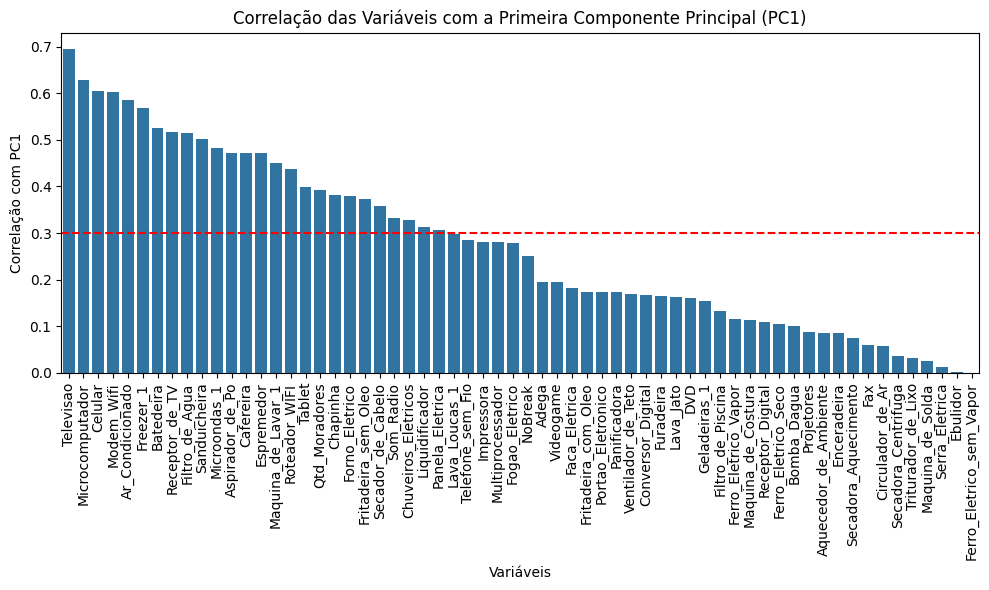

In [50]:
# Calcular a correlação entre as variáveis originais e a primeira componente principal pela correlação de spearman
corr_with_PC1 = dados_sem_classe.apply(lambda x: x.corr(pd.Series(pca_components[:, 0]), method='spearman'))

# Ordenar as variáveis por correlação absoluta com a primeira componente principal
corr_with_PC1_sorted = corr_with_PC1.abs().sort_values(ascending=False)

# Criar um gráfico de barras para visualizar as correlações
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_PC1_sorted.index, y=corr_with_PC1_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Correlação com PC1')
plt.title('Correlação das Variáveis com a Primeira Componente Principal (PC1)')
plt.axhline(y=corre, color='red', linestyle='--', linewidth=1.5)
plt.tight_layout()
plt.show()

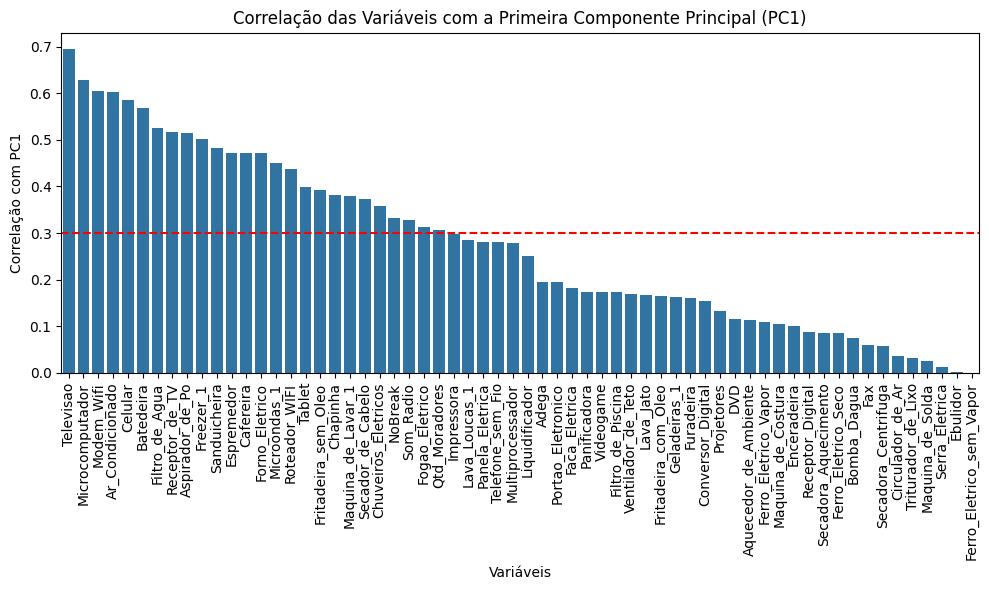

In [51]:
# Calcular a correlação entre as variáveis originais e a primeira componente principal pela correlação de Pearson
corr2_with_PC1 = dados_sem_classe.apply(lambda x: x.corr(pd.Series(pca_components[:, 0]), method='pearson'))

# Ordenar as variáveis por correlação absoluta com a primeira componente principal
corr2_with_PC1_sorted = corr2_with_PC1.abs().sort_values(ascending=False)

# Criar um gráfico de barras para visualizar as correlações
plt.figure(figsize=(10, 6))
sns.barplot(x=corr2_with_PC1_sorted.index, y=corr_with_PC1_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Correlação com PC1')
plt.title('Correlação das Variáveis com a Primeira Componente Principal (PC1)')
plt.axhline(y=corre, color='red', linestyle='--', linewidth=1.5)
plt.tight_layout()
plt.show()

In [55]:
# Filtrar variáveis com maior correlação
selected_vars = corr2_with_PC1_sorted[corr2_with_PC1_sorted > corre].index

In [56]:
# Criar um novo dataframe com as variáveis selecionadas
df_selected = dados_sem_classe[selected_vars].copy()

# Adicionar a coluna CLASSE ao novo dataframe
df_selected['CLASSE'] = classe_1.reset_index(drop=True)

In [57]:
#Novo dataframe com as variaveis mais correlatadas com a primeira componente principal

df_selected.head()
#print(df_selected.shape)

,Televisao,Microcomputador,Modem_Wifi,Ar_Condicionado,Celular,Batedeira,Filtro_de_Agua,Receptor_de_TV,Aspirador_de_Po,Freezer_1,...,NoBreak,Som_Radio,Fogao_Eletrico,Qtd_Moradores,Impressora,Lava_Loucas_1,Panela_Eletrica,Telefone_sem_Fio,Multiprocessador,CLASSE
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,C1
1,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,C2
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,DE
3,2.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,B2
4,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,C1


Aplicando redução pelo coeficiente de spearman

In [58]:
# Calcular a correlação de Spearman para as variáveis
spearman_corr = dados_sem_classe.corr(method='spearman')

In [59]:
# Definir um limiar (threshold) para selecionar as variáveis com alta correlação
threshold = 0.3

In [60]:
# Selecionar as variáveis mais correlacionadas
correlated_vars = np.where(np.abs(spearman_corr) > threshold)
correlated_vars = [(spearman_corr.index[x], spearman_corr.columns[y]) for x, y in zip(*correlated_vars) if x != y]

In [62]:
# Exibir a matriz de correlação
spearman_corr.head()

,Qtd_Moradores,Maquina_de_Lavar_1,Geladeiras_1,Freezer_1,Microcomputador,Lava_Loucas_1,Microondas_1,Ar_Condicionado,Televisao,Batedeira,...,Secadora_Aquecimento,Secadora_Centrifuga,Aquecedor_de_Ambiente,Ventilador_de_Teto,Circulador_de_Ar,Videogame,Som_Radio,Filtro_de_Agua,Adega,Chuveiros_Eletricos
Qtd_Moradores,1.000000,0.189698,0.159700,0.220184,0.189814,0.039492,0.176818,0.127549,0.323250,0.199997,...,0.057502,0.076312,-0.031029,0.166776,0.183768,0.161385,0.068233,0.011826,0.007329,0.192097
Maquina_de_Lavar_1,0.189698,1.000000,0.104173,0.340657,0.289392,0.088260,0.376825,0.287609,0.293095,0.164071,...,0.016951,0.041188,0.039554,0.088772,-0.036574,0.063096,0.186411,0.139100,0.032717,0.171308
Geladeiras_1,0.159700,0.104173,1.000000,0.146783,0.135734,0.031018,0.116688,0.121494,0.158315,0.042224,...,0.060488,0.015376,-0.022821,0.059523,-0.021722,0.016991,-0.017728,-0.036903,-0.029571,0.171176
Freezer_1,0.220184,0.340657,0.146783,1.000000,0.400175,0.209380,0.378735,0.348615,0.392710,0.191230,...,0.012515,0.035852,0.017989,0.241406,-0.000800,0.054537,0.131972,0.265226,0.113163,0.228327
Microcomputador,0.189814,0.289392,0.135734,0.400175,1.000000,0.269351,0.384409,0.409379,0.456046,0.271541,...,0.020031,0.094913,0.043198,0.084692,-0.102692,0.097146,0.238300,0.246136,0.126250,0.249473


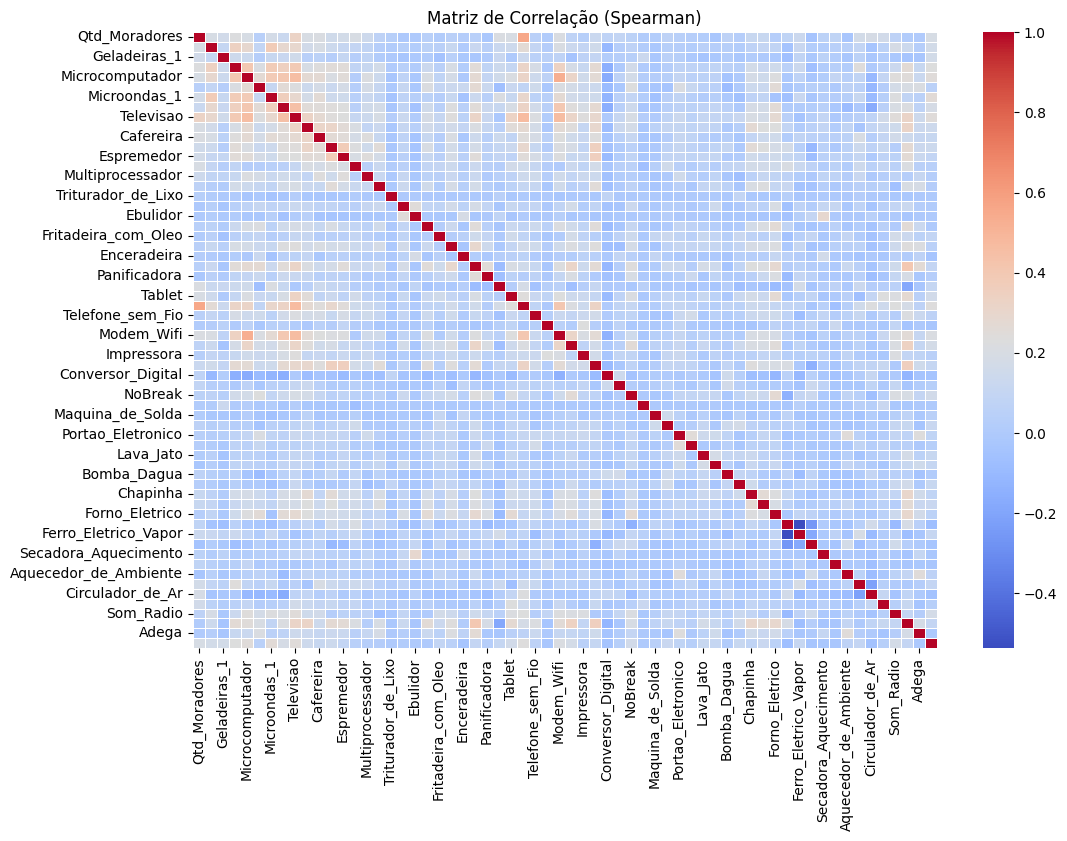

In [63]:
# Plotar o heatmap da matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação (Spearman)')
plt.show()

In [64]:
# Remover duplicatas e manter uma cópia da variável apenas
selected_columns = list(set([var[0] for var in correlated_vars]))

In [65]:
# Criar um novo dataframe com essas variáveis correlacionadas
df_spearman = dados_sem_classe[selected_columns].copy()


In [66]:
# Adicionar a coluna da variável alvo
df_spearman['CLASSE'] = classe_1.reset_index(drop=True)


In [67]:
# Exibir as primeiras linhas do novo DataFrame
df_spearman.head()

,Televisao,Freezer_1,Maquina_de_Lavar_1,Ar_Condicionado,Roteador_WIFI,Microondas_1,Batedeira,Ferro_Eletrico_Seco,Cafereira,Celular,...,Tablet,Sanduicheira,Receptor_de_TV,Qtd_Moradores,Filtro_de_Agua,Microcomputador,Espremedor,Aspirador_de_Po,Ferro_Eletrico_Vapor,CLASSE
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,C1
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,C2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,DE
3,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,B2
4,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,C1


O algoritmo não encontrou variáveis correlatadas com mais de 70%, por isso será criado um dataframe com as variáveis que possuem maior correlação com as variáveis de saída.

In [68]:
#Correlação a ser selecionada

cor = 0.15

In [69]:
# Converter a variável categórica 'classe_1' para valores numéricos
classe_1_numerica = pd.factorize(classe_1)[0]


In [70]:
# Calcular a correlação de Spearman entre as variáveis de entrada e a variável de saída numérica
spearman_corr_with_target = dados_sem_classe.apply(lambda x: x.corr(pd.Series(classe_1_numerica), method='spearman'))

In [71]:
# Ordenar as variáveis por ordem de correlação (absoluta) com a variável de saída
spearman_corr_with_target = spearman_corr_with_target.abs().sort_values(ascending=False)

In [72]:
# Exibir a correlação de cada variável de entrada com a variável de saída
print(spearman_corr_with_target)


Microcomputador         0.316221
Lava_Loucas_1           0.297979
Modem_Wifi              0.238771
Ar_Condicionado         0.234383
Televisao               0.212886
                          ...   
Enceradeira             0.007237
Panela_Eletrica         0.004807
Filtro_de_Agua          0.001983
Sanduicheira            0.001894
Ferro_Eletrico_Vapor    0.000788
Length: 62, dtype: float64


In [73]:
# Filtrar as variáveis que têm correlação maior que 0.5 em valor absoluto
selected_features = spearman_corr_with_target[spearman_corr_with_target > cor].index

In [74]:
# Criar um novo DataFrame apenas com essas variáveis
df_high_corr = dados_sem_classe[selected_features].copy()

In [75]:
# Adicionar a coluna da variável alvo
df_high_corr['CLASSE'] = classe_1.reset_index(drop=True)

In [76]:
# Exibir as primeiras linhas do novo DataFrame
print(df_high_corr.head(10))

   Microcomputador  Lava_Loucas_1  Modem_Wifi  Ar_Condicionado  Televisao  \
0              0.0            0.0         0.0              0.0        1.0   
1              1.0            0.0         0.0              0.0        2.0   
2              0.0            0.0         0.0              0.0        1.0   
3              1.0            0.0         0.0              1.0        2.0   
4              1.0            0.0         0.0              0.0        2.0   
5              0.0            0.0         0.0              0.0        1.0   
6              0.0            0.0         0.0              0.0        1.0   
7              2.0            0.0         1.0              0.0        2.0   
8              1.0            0.0         1.0              0.0        3.0   
9              1.0            0.0         1.0              0.0        2.0   

   Som_Radio  NoBreak  Multiprocessador  Chuveiros_Eletricos CLASSE  
0        1.0      0.0               0.0                  1.0     C1  
1        0.0

In [77]:
df_high_corr

,Microcomputador,Lava_Loucas_1,Modem_Wifi,Ar_Condicionado,Televisao,Som_Radio,NoBreak,Multiprocessador,Chuveiros_Eletricos,CLASSE
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,C1
1,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,C2
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,DE
3,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,B2
4,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,C1
...,...,...,...,...,...,...,...,...,...,...
1091,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,DE
1092,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,C1
1093,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,C2
1094,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,C1


DataFrames criados até aqui:

df_pca - Componentes principais;
df_selected - Variaveis com maior correlacao com a Primeira Componente Principal;
df_spearman - Remoção das variáveis mais correlatadas;
df_high_corr - Variaveis de entrada com maior correlação com as variáveis de saída;

In [78]:
df_pca.head(10)
df_pca.to_csv('df_pca.csv', index=False)

In [80]:
df_selected.head(10)
df_selected.to_csv('df_CP1.csv', index=False)

In [81]:
df_spearman.head(5)
df_spearman.to_csv('df_spearman.csv', index=False)

In [82]:
df_high_corr.head(10)
df_high_corr.to_csv('df_spearman_direto.csv', index=False)